In [39]:
import os
import pandas as pd
import matplotlib.pyplot as plt

OUTPUT_FOLDER = "output-aws"
TIME = 360
GPT = 30
NOW = 99
ALL_DATABASES = ["postgres", "xtdb2"]

In [40]:
# HELPER FUNCTIONS
def make_path(database, mode, time, gpt, now, users, rate):
    return f"{OUTPUT_FOLDER}/{database}/{mode}/time-{time}-users-{users}-gpt-{gpt}-now-{now}-rate-{rate}"


def parse_size(size_str):
    size_str = size_str.strip()
    number, unit = size_str.split()
    number = float(number)
    unit_multipliers = {
        "B": 1,
        "KiB": 1024,
        "MiB": 1024 ** 2,
        "GiB": 1024 ** 3,
    }
    return int(number * unit_multipliers[unit])

# 1. Compare Space in State vs Update based

In [41]:
def load_all_data(path):
    # Load both files
    size_df = pd.read_csv(os.path.join(path, "size.csv"), parse_dates=["timestamp"])
    size_query_df = pd.read_csv(os.path.join(path, "size_query.csv"), parse_dates=["timestamp"])
    size_query_df["value"] = size_query_df["value"].apply(parse_size)
    times_df = pd.read_csv(os.path.join(path, "times.csv"), parse_dates=["timestamp"])

    # Pivot metrics in size.csv
    size_df = size_df.pivot(index="timestamp", columns="metric", values="value").reset_index()
    size_query_df = size_query_df.pivot(index="timestamp", columns="metric", values="value").reset_index()

    # Only the ALL PUT metric is needed from times.csv
    times_df = times_df[times_df["label"] == "ALL PUT"]
    times_df = times_df.pivot(index="timestamp", columns="label", values="count").reset_index()

    times_df.columns.name = None
    times_df.columns = times_df.columns.astype(str)

    # Merge based on nearest timestamps
    if size_query_df.empty:
        merged = pd.merge_asof(size_df, times_df, on="timestamp", suffixes=('', '_time'))
    else:
        merged = pd.merge_asof(size_df, size_query_df, on="timestamp", suffixes=('_size', '_query'))
        merged = pd.merge_asof(merged, times_df, on="timestamp", suffixes=('', '_time'))

    return merged

def load_time_data(path):
    # Load the times.csv file
    times_df = pd.read_csv(os.path.join(path, "times.csv"), parse_dates=["timestamp"])
    return times_df
    

## Postgres

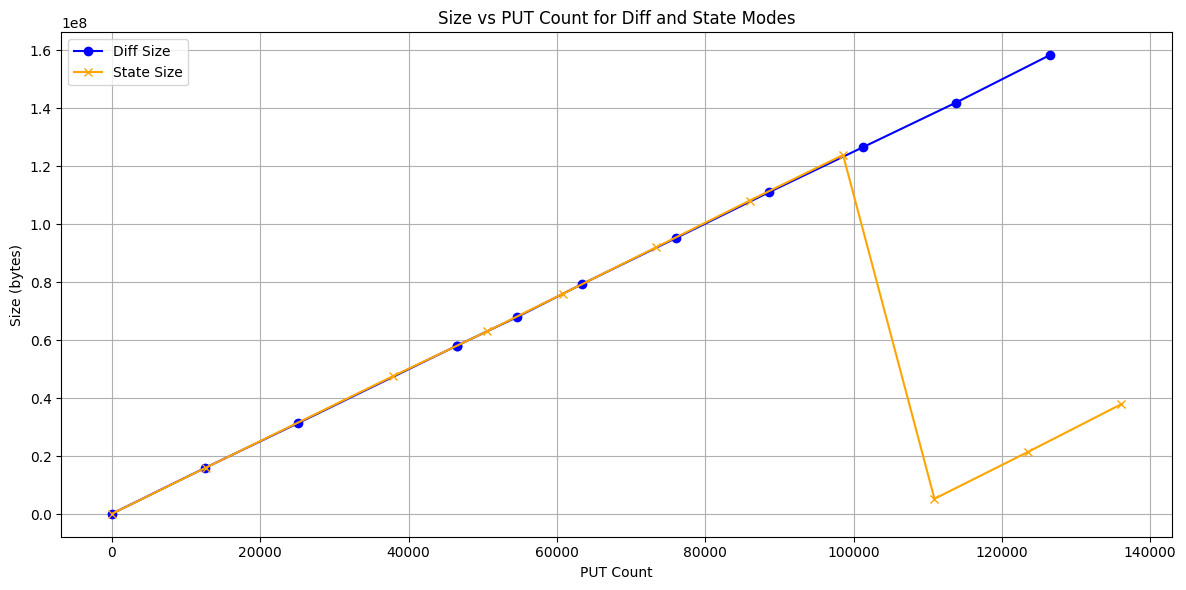

In [42]:
database = "postgres"
users = 1
rate = 10

diff_path = make_path(database, "diff", TIME, GPT, NOW, users, rate)
state_path = make_path(database, "state", TIME, GPT, NOW, users, rate)

diff_data = load_all_data(diff_path)
state_data = load_all_data(state_path)

# Plotting the data - I want the PUT count on the x-axis and the size on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(diff_data['ALL PUT'], diff_data['customer_diff_total'], label='Diff Size', color='blue', marker='o')
plt.plot(state_data['ALL PUT'], state_data['customer_state_total'], label='State Size', color='orange', marker='x')
plt.xlabel('PUT Count')
plt.ylabel('Size (bytes)')
plt.title('Size vs PUT Count for Diff and State Modes')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## XTDB2

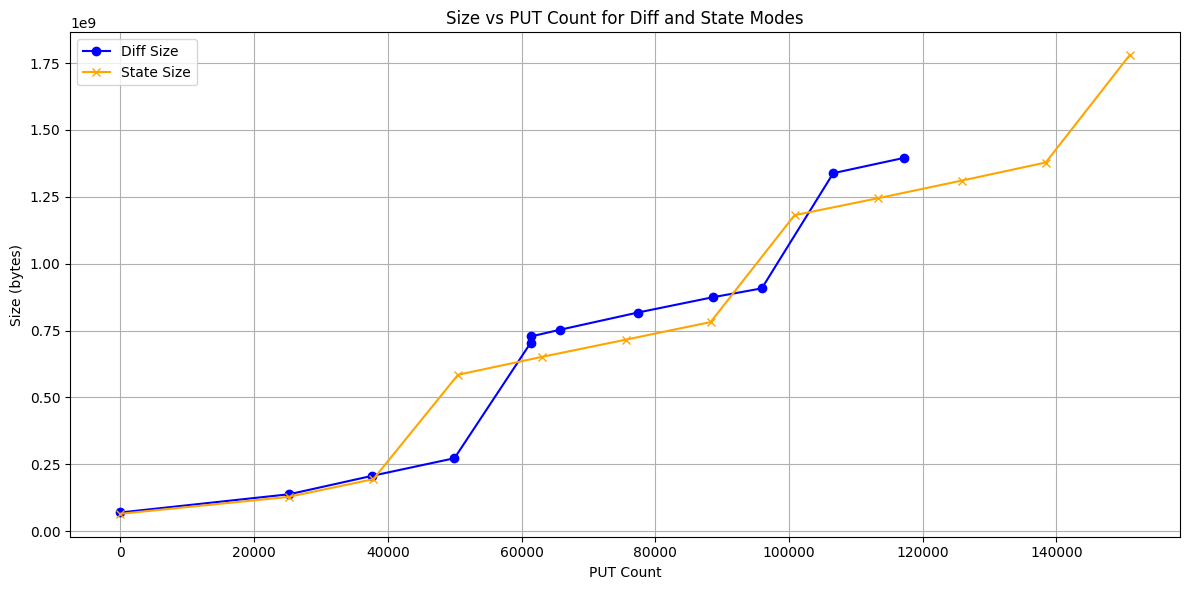

In [43]:
database = "xtdb2"
users = 1
rate = 10

diff_path = make_path(database, "diff", TIME, GPT, NOW, users, rate)
state_path = make_path(database, "state", TIME, GPT, NOW, users, rate)

diff_data = load_all_data(diff_path)
state_data = load_all_data(state_path)

# Plotting the data - I want the PUT count on the x-axis and the size on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(diff_data['ALL PUT'], diff_data['total_size'], label='Diff Size', color='blue', marker='o')
plt.plot(state_data['ALL PUT'], state_data['total_size'], label='State Size', color='orange', marker='x')
plt.xlabel('PUT Count')
plt.ylabel('Size (bytes)')
plt.title('Size vs PUT Count for Diff and State Modes')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## TerminusDB

# 2. Compare time distribution in databases and state vs update

## PUT Time distribution

In [45]:
#From all the csv, get only the times correspondent to the latest timestamp
#Do an boxplot of the time distribution for each label (PUT, GET, etc.), use the median, 25 and 75 percentiles
#On the x-axis, put the label (PUT, GET, etc.)
#On the y-axis, put the time in seconds

users = 1
rate = 10


all_filtered_rows = []

for database in ALL_DATABASES:
    diff_path = make_path(database, "diff", TIME, GPT, NOW, users, rate)
    state_path = make_path(database, "state", TIME, GPT, NOW, users, rate)

    # Load CSVs
    diff_times = load_time_data(diff_path)
    state_times = load_time_data(state_path)

    # Filter for the latest timestamp
    latest_diff_timestamp = diff_times['timestamp'].max()
    latest_state_timestamp = state_times['timestamp'].max()
    diff_filtered = diff_times[diff_times['timestamp'] == latest_diff_timestamp]
    state_filtered = state_times[state_times['timestamp'] == latest_state_timestamp]

    display(diff_filtered)
    display(state_filtered)

,timestamp,label,count,avg,min,max,p25,p50,p75,p90,p99
69,2025-06-14 21:34:41,ALL PUT,131361,0.003369,0.001796,0.142792,0.003242,0.003376,0.003493,0.003605,0.003807
70,2025-06-14 21:34:41,PutType.MOST_RECENT,131361,0.003369,0.001796,0.142792,0.003242,0.003376,0.003493,0.003605,0.003807
71,2025-06-14 21:34:41,ALL GET,56184,0.003516,0.001917,0.081782,0.003403,0.003531,0.003629,0.003719,0.003931
72,2025-06-14 21:34:41,GetType.CURRENT,55652,0.003516,0.001917,0.081782,0.003403,0.003531,0.003629,0.003719,0.003931
73,2025-06-14 21:34:41,GetType.TIMESTAMP,396,0.003532,0.002872,0.004010,0.003400,0.003554,0.003665,0.003741,0.003927
74,2025-06-14 21:34:41,GetType.NO_USER_AT_TIME,136,0.003406,0.002919,0.003726,0.003310,0.003420,0.003510,0.003589,0.003708


,timestamp,label,count,avg,min,max,p25,p50,p75,p90,p99
73,2025-06-14 14:54:42,PutType.MOST_RECENT,130131,0.004171,0.002141,0.257156,0.003922,0.004172,0.004416,0.004620,0.004938
74,2025-06-14 14:54:42,PutType.PAST,5953,0.004690,0.003382,0.014048,0.004365,0.004678,0.004983,0.005265,0.005872
75,2025-06-14 14:54:42,ALL GET,57807,0.003210,0.001880,0.194318,0.003047,0.003221,0.003365,0.003469,0.003686
76,2025-06-14 14:54:42,GetType.CURRENT,44858,0.003253,0.001934,0.045325,0.003114,0.003271,0.003393,0.003490,0.003703
77,2025-06-14 14:54:42,GetType.TIMESTAMP,333,0.003270,0.002571,0.003869,0.003118,0.003307,0.003431,0.003495,0.003735
78,2025-06-14 14:54:42,GetType.NO_USER_AT_TIME,12616,0.003058,0.001880,0.194318,0.002907,0.003029,0.003169,0.003277,0.003488


,timestamp,label,count,avg,min,max,p25,p50,p75,p90,p99
68,2025-06-13 20:37:41,ALL PUT,119416,0.009362,0.005045,58.887517,0.008313,0.008675,0.008976,0.009353,0.013311
69,2025-06-13 20:37:41,PutType.MOST_RECENT,119416,0.009362,0.005045,58.887517,0.008313,0.008675,0.008976,0.009353,0.013311
70,2025-06-13 20:37:41,ALL GET,50976,0.108534,0.010865,1.424417,0.076494,0.119360,0.141894,0.162699,0.175090
71,2025-06-13 20:37:41,GetType.CURRENT,50428,0.108478,0.010865,0.943783,0.076455,0.119393,0.141888,0.162676,0.175015
72,2025-06-13 20:37:41,GetType.TIMESTAMP,423,0.116601,0.014695,1.424417,0.080407,0.117835,0.145911,0.166160,0.224171
73,2025-06-13 20:37:41,GetType.NO_USER_AT_TIME,125,0.103673,0.011170,0.225239,0.071018,0.115958,0.126843,0.154471,0.192781


,timestamp,label,count,avg,min,max,p25,p50,p75,p90,p99
79,2025-06-14 09:23:14,ALL PUT,150955,0.026659,0.015083,3.218793,0.019509,0.024417,0.031117,0.036338,0.049883
80,2025-06-14 09:23:14,PutType.MOST_RECENT,144152,0.026274,0.015083,3.218793,0.018496,0.024097,0.030910,0.035518,0.048972
81,2025-06-14 09:23:14,PutType.PAST,6803,0.034814,0.021694,2.969558,0.028362,0.032480,0.038637,0.044917,0.061807
82,2025-06-14 09:23:14,ALL GET,64620,0.011584,0.006155,1.607967,0.007543,0.010597,0.014126,0.015704,0.022456
83,2025-06-14 09:23:14,GetType.CURRENT,63961,0.011581,0.006155,1.607967,0.007542,0.010596,0.014124,0.015698,0.022420
84,2025-06-14 09:23:14,GetType.TIMESTAMP,504,0.011834,0.006805,0.046752,0.007689,0.010800,0.014334,0.015707,0.026210
85,2025-06-14 09:23:14,GetType.NO_USER_AT_TIME,155,0.012005,0.006283,0.025574,0.007395,0.010685,0.014718,0.018259,0.023331
